Code for calculating the CEvNS

TODO:
- Add more form factor options
- Add axial-vector form factor calculation
- Add pion decay-at-rest neutrino source
- Add histogram neutrino source
- Add radiative corrections
- Add NSI couplings

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import sys
import pandas as pd
from utils import ioUtils, sourceUtils, targetUtils, cevnsUtils
from utils.constants import constants

################
##Parse Config##
################
configFileName = "config/LiF_reactor.jsonc"
config = ioUtils.parseConfig(configFileName)

#Load mass table. Indexed by symbol, and has:
# Z, A, nuc_mass_MeV, atom_mass_MeV
mass_dict = ioUtils.loadMassDict("data/mass_1.mas20.txt")
#Load spin density table. Indexed by symbol, and has:
# Sn, Sp
spinDensity_dict = ioUtils.loadSnSpDict("data/sn_sp.csv")

#Make CEvNS nuclear targets. Indexed by symbol, and has:
# symbol,Z,A,N,nuc_mass_MeV,atom_mass_MeV,atom_frac,mass_frac,num_atoms,mass,sn,sp
targetObjects = targetUtils.makeTargets(config=config,mass_dict=mass_dict,spinDensity_dict=spinDensity_dict) 

# raw_energies, raw_flux, interpolated_energies, interpolated_flux, normalized_flux (nu /cm2/sec)
#For reactors: flux is given as neutrinos per fission per MeV
fluxObjects = sourceUtils.makeFluxObjects(config=config)

#Adds an xs_cm2, Enus_MeV, normalized_flux to each target
results = cevnsUtils.calc_xs(fluxObject=fluxObjects["total"],targetObjects=targetObjects,config=config)

#Plotting
colors=["tab:blue","tab:orange","tab:green","tab:red","tab:purple","black"]
plt.rcParams.update({'axes.titlesize': 14})
plt.rcParams.update({'axes.labelsize': 15})
plt.rcParams.update({'xtick.labelsize':13})
plt.rcParams.update({'ytick.labelsize':13}) 
plt.rcParams.update({'legend.fontsize':13}) 

Per 235U fission, raw values give 3.26 neutrinos/fission
Per 235U fission, interpolated values give 3.26 neutrinos/fission
Per 238U fission, raw values give 4.16 neutrinos/fission
Per 238U fission, interpolated values give 4.16 neutrinos/fission
Per 239Pu fission, raw values give 2.78 neutrinos/fission
Per 239Pu fission, interpolated values give 2.78 neutrinos/fission
Per 241Pu fission, raw values give 3.45 neutrinos/fission
Per 241Pu fission, interpolated values give 3.45 neutrinos/fission

1.0 GWth reactor produces 3.031e+19 fissions/sec
Total neutrino flux 20.0m from a 1.0 GWth reactor is 1.924e+12 nu/cm2/sec


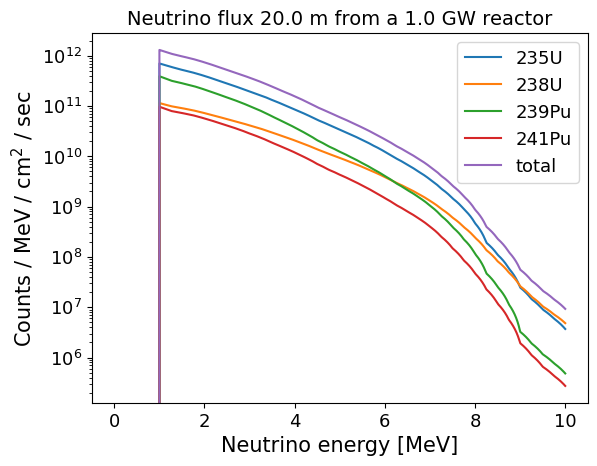

In [2]:
fig,ax = plt.subplots()

for name, fluxObject in fluxObjects.items():
  ax.plot(fluxObject.interpolated_energies_MeV,fluxObject.normalized_flux,label=name)

ax.set_yscale("log")  
ax.legend()
ax.set_xlabel("Neutrino energy [MeV]")
ax.set_ylabel("Counts / MeV / cm$^2$ / sec")
ax.set_title(f"Neutrino flux {config['source']['params']['distance_m']} m from a {config['source']['params']['power_GWth']} GW reactor")
plt.show()

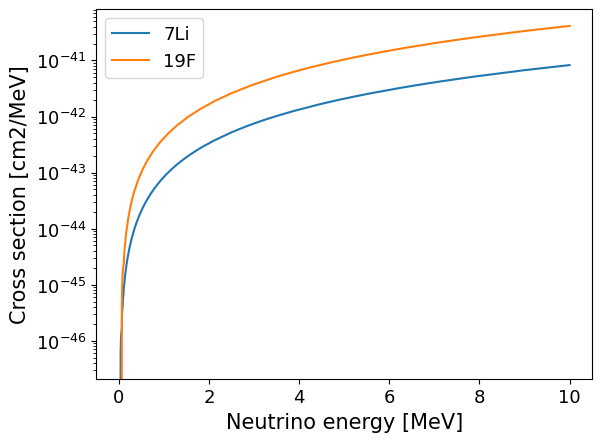

In [3]:
fig2,ax2 = plt.subplots()
for targetName,target in targetObjects.items():
  ax2.plot(results.Enus_MeV,results.total_xs_cm2[targetName],label=targetName)

ax2.set_yscale("log")
ax2.legend()
ax2.set_xlabel("Neutrino energy [MeV]")
ax2.set_ylabel("Cross section [cm2/MeV]")
plt.show()

Counts/sec/0.77-kg 7Li: 7.411e-06
Counts/sec/0.23-kg 19F: 3.703e-05


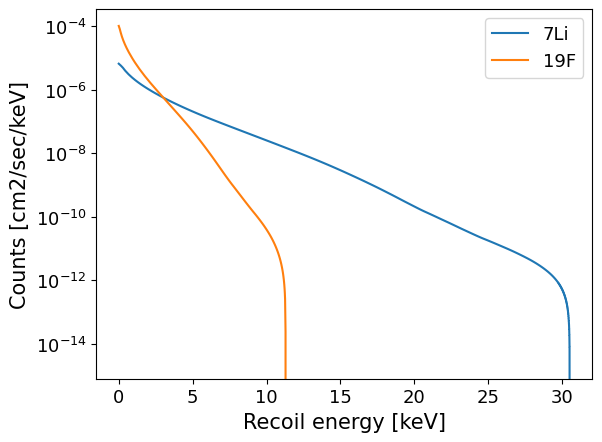

In [6]:
fig2,ax2 = plt.subplots()
for targetName,target in targetObjects.items():
  ax2.plot(results.Enrs_keV,results.normalized_recoil_spectrum_keV[targetName],label=targetName)
  print(f"Counts/sec/{target.mass:.2f}-kg {targetName}: {results.total_counts[targetName]:.3e}")
  
ax2.set_yscale("log")
ax2.legend()
ax2.set_xlabel("Recoil energy [keV]")
ax2.set_ylabel("Counts [cm2/sec/keV]")
plt.show()

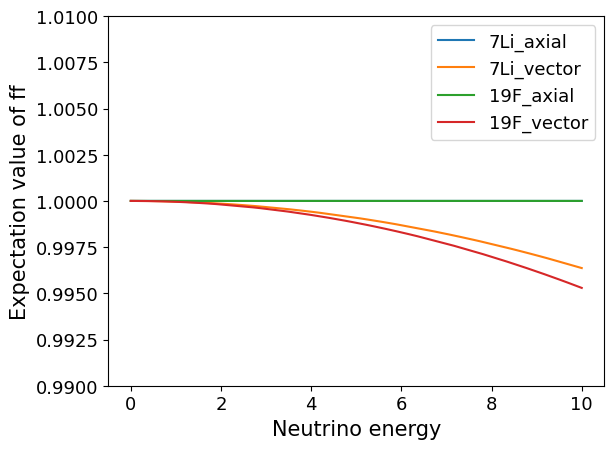

In [22]:
fig2,ax2 = plt.subplots()
for targetName,target in targetObjects.items():
  ax2.plot(results.Enus_MeV,results.axial_ff_exp[targetName],label=targetName+"_axial")
  ax2.plot(results.Enus_MeV,results.vector_ff_exp[targetName],label=targetName+"_vector")
  
ax2.set_ylim(0.99,1.01)
ax2.legend()
ax2.set_xlabel("Neutrino energy")
ax2.set_ylabel("Expectation value of ff")
plt.show()